In [283]:
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec

In [ ]:
#import relevant data
with_time = True
if with_time:
    control_data = pd.read_csv("./cleaned_data/control_w_time.csv", index_col = 0)
    case_data = pd.read_csv("./cleaned_data/case_w_time.csv", index_col = 0)
    all_events = pd.read_csv("./cleaned_data/events_id_w_time.csv", index_col = 0)
    word2vec_model = Word2Vec.load("./word2vec_model/w2vmodel_wt")
    
    control_demo = pd.read_csv("./cleaned_data/control_demo_wt.csv", index_col = 0)
    case_demo = pd.read_csv("./cleaned_data/case_demo_wt.csv", index_col = 0)
else:
    control_data = pd.read_csv("./cleaned_data/control.csv", index_col = 0)
    case_data = pd.read_csv("./cleaned_data/case.csv", index_col = 0)
    all_events = pd.read_csv("./cleaned_data/events_id.csv", index_col = 0)
    word2vec_model = Word2Vec.load("./word2vec_model/w2vmodel")
    
    control_demo = pd.read_csv("./cleaned_data/control_demo.csv", index_col = 0)
    case_demo = pd.read_csv("./cleaned_data/case_demo.csv", index_col = 0)

In [351]:
#construct an input list of arrays with event index (start from 1)
control_temp = control_data.groupby("SUBJECT_ID").apply(lambda x: x.EVE_INDEX.values)
case_temp = case_data.groupby("SUBJECT_ID").apply(lambda x: x.EVE_INDEX.values)

control_temp = control_temp.sort_index()
case_temp = case_temp.sort_index()

In [352]:
control_patients = control_temp.index.values
case_patients = case_temp.index.values
all_patients = np.concatenate([control_patients,case_patients])

In [353]:
#construct labels
Y_control = np.zeros(len(control_patients))
Y_case = np.ones(len(case_patients))
Y = np.concatenate([Y_control,Y_case])

In [354]:
#set up demographic input layer 
#group by operation automatic sorts the subject id so demographic data is in the same order as events data)
X_demo_control = control_demo.sort_values(by="SUBJECT_ID")
X_demo_case = case_demo.sort_values(by="SUBJECT_ID")
X_demo = np.concatenate([X_demo_control.ix[:,1:3].values ,X_demo_case.ix[:,1:3].values])

In [355]:
#find maximum number of events(used for set the parameters of embedding layer
#all sequences of events are padded to the max length)
c_max = control_data.groupby("SUBJECT_ID")["EVE_INDEX"].count().max()
ca_max = case_data.groupby("SUBJECT_ID")["EVE_INDEX"].count().max()
max_num_event_patient = np.max([c_max,ca_max])

In [356]:
#contruct training set of sequences with paddings, so all the sequence has the same length of max_length, 
#with 0s padded before in shorter sequences
np.random.seed(seed=6250)
from keras.preprocessing.sequence import pad_sequences

X_control = [np.array(events).astype("int") for events in control_temp]
X_case = [np.array(events).astype("int") for events in case_temp]
X_all = np.concatenate([X_control,X_case])

X = pad_sequences(X_all, maxlen=None)

In [357]:
X.shape

(1944, 492)

In [358]:
print(X[0].shape[0])
print (X.shape)
print (Y.shape)

492
(1944, 492)
(1944,)


In [359]:
#shuffle
shuffled_index = np.random.permutation(len(all_patients))

#split train, dev, test set 7:1:2
train_index = shuffled_index[:int(len(all_patients)*0.7)]
dev_index =  shuffled_index[int(len(all_patients)*0.7):int(len(all_patients)*0.8)]
test_index =  shuffled_index[int(len(all_patients)*0.8):]

In [360]:
print (shuffled_index.shape)
print (train_index.shape, dev_index.shape, test_index.shape)

(1944,)
((1360,), (195,), (389,))


In [361]:
all_patients_shuffle = all_patients[shuffled_index]

Y_train = Y[train_index]
Y_dev = Y[dev_index]
Y_test = Y[test_index]

X_train = X[train_index]
X_dev = X[dev_index]
X_test = X[test_index]

X_demo_train = X_demo[train_index]
X_demo_dev = X_demo[dev_index]
X_demo_test = X_demo[test_index]

In [362]:
#contruct embedding matrix dim of (number of different events, dim of embedding)
num_events = len(all_events)
dim_embedding = len(word2vec_model.wv["1"])
#adding the dummy row for padding at index "0"
embedding_matrix = np.zeros((num_events+1, dim_embedding))
for i in range(1, num_events+1):
    embedding_matrix[i] = word2vec_model.wv[str(i)]

In [363]:
embedding_matrix.shape

(5485, 100)

In [364]:
print (embedding_matrix.shape)

(5485, 100)


In [365]:
max_num_event_patient

492

In [409]:
#set up the model
from keras.layers import Conv1D, Dense, Input,GlobalMaxPooling1D, MaxPooling1D, concatenate, Embedding,BatchNormalization, Dropout
from keras.optimizers import SGD, Adam, RMSprop,Nadam
from keras.models import Model
from keras.models import load_model
from keras.initializers import glorot_normal

input_events = Input(shape=(max_num_event_patient,))
init = glorot_normal(seed = 6250)

#embedding layer
embedding_raw = Embedding(num_events+1, dim_embedding,embeddings_initializer = init, input_length=max_num_event_patient)(input_events)
embedding = BatchNormalization()(embedding_raw)
#1D conv
x_2 = Conv1D(filters = 4, kernel_size = 2,padding = "valid", activation='relu')(embedding)
x_3 = Conv1D(filters = 4, kernel_size = 3,padding = "valid", activation='relu')(embedding)
x_4 = Conv1D(filters = 4, kernel_size = 4,padding = "valid", activation='relu')(embedding)
x_5 = Conv1D(filters = 4, kernel_size = 5,padding = "valid", activation='relu')(embedding)

pool_2 = GlobalMaxPooling1D()(x_2)
pool_3 = GlobalMaxPooling1D()(x_3)
pool_4 = GlobalMaxPooling1D()(x_4)
pool_5 = GlobalMaxPooling1D()(x_5)

#need to adjust the shape for demographics if demo feature changes
#now its age, sex (tried ethnicity(one hot dim = 5) but not working well)

input_demo = Input(shape=(2,))

#concatenate max_pooling results
patient_embed = concatenate([input_demo,pool_2, pool_3,pool_4,pool_5])

#fully connected part
dense1 = Dense(6, activation = "relu")(patient_embed)
dense1 = Dropout(0.2)(dense1)
output = Dense(1, activation = "sigmoid" )(dense1)

model = Model(inputs=[input_events, input_demo], outputs=output)
model.compile(optimizer=Nadam(lr = 0.0005),loss='binary_crossentropy',metrics=['accuracy'])

In [414]:
model.fit([X_train, X_demo_train],Y_train, epochs=20,batch_size =64,shuffle=True,validation_data=([X_dev, X_demo_dev], Y_dev))

Train on 1360 samples, validate on 195 samples
Epoch 1/20
1360/1360 [==============================] - 0s - loss: 0.0817 - acc: 0.9662 - val_loss: 0.0653 - val_acc: 0.9692
Epoch 2/20
1360/1360 [==============================] - 0s - loss: 0.0960 - acc: 0.9603 - val_loss: 0.0665 - val_acc: 0.9744
Epoch 3/20
1360/1360 [==============================] - 0s - loss: 0.0856 - acc: 0.9691 - val_loss: 0.0701 - val_acc: 0.9692
Epoch 4/20
1360/1360 [==============================] - 0s - loss: 0.0852 - acc: 0.9691 - val_loss: 0.0761 - val_acc: 0.9692
Epoch 5/20
1360/1360 [==============================] - 0s - loss: 0.0959 - acc: 0.9654 - val_loss: 0.0821 - val_acc: 0.9692
Epoch 6/20
1360/1360 [==============================] - 0s - loss: 0.0949 - acc: 0.9610 - val_loss: 0.0690 - val_acc: 0.9692
Epoch 7/20
1360/1360 [==============================] - 0s - loss: 0.0851 - acc: 0.9743 - val_loss: 0.0674 - val_acc: 0.9641
Epoch 8/20
1360/1360 [==============================] - 0s - loss: 0.0867 - ac

In [417]:
!rm cnn-model.h5
model.save('cnn-model.h5')

In [415]:
model.evaluate([X_test, X_demo_test], Y_test)

352/389 [==========================>...] - ETA: 0s

[0.3752443756284411, 0.94344473007712082]

In [416]:
from sklearn import metrics
print metrics.roc_auc_score(Y_test, model.predict([X_test, X_demo_test]))

0.968867924528


## Visualize patient representation trained by CNN

In [418]:
#get embedding
patient_embedding=Model(inputs=[input_events, input_demo], outputs=patient_embed).predict([X, X_demo])


In [419]:
patient_embedding.shape

(1944, 18)

In [420]:
from sklearn.manifold import TSNE
from time import time


Computing t-SNE embedding
t-SNE: 30 sec


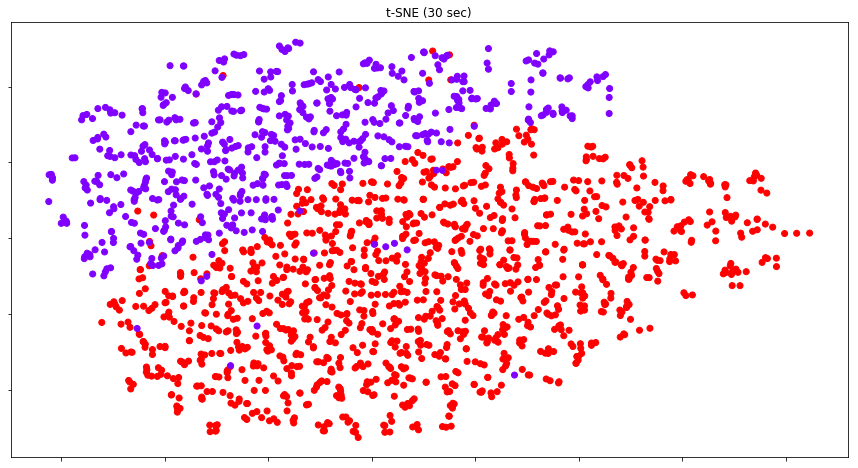

In [421]:
#use t-sne to visualize patient representations in control group and case group
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity =2,init='pca', random_state=0,method='exact')
t0 = time()
patient_tsne = tsne.fit_transform(patient_embedding)

t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn.utils import check_random_state

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1,1,1)
plt.scatter(patient_tsne[:,0], patient_tsne[:,1], c=Y,cmap=plt.cm.rainbow_r)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

## Doing  Kmeans upon learned feature embeddings

In [422]:
#get case embeddings
case_embedding = patient_embedding[Y==1]

In [423]:
case_embedding.shape

(648, 18)

In [424]:
from sklearn.cluster import KMeans
%matplotlib inline 

In [425]:
kmeans_wss=[]
kmeans_idx=[]
for i in range(2,20):

    kmeans_clustering = KMeans( n_clusters = i).fit(case_embedding)
    kmeans_idx.append(kmeans_clustering.labels_)
    kmeans_wss.append(kmeans_clustering.inertia_)



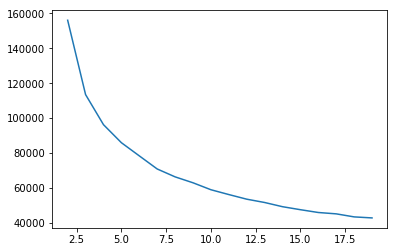

In [426]:
#find good # of clusters 
plt.plot(range(2,20), kmeans_wss)

## Visualize 3 clusters in case group using pateint representation 

In [427]:
case_class = KMeans(n_clusters = 3).fit(case_embedding).labels_ +1

Computing t-SNE embedding
t-SNE: 6 sec


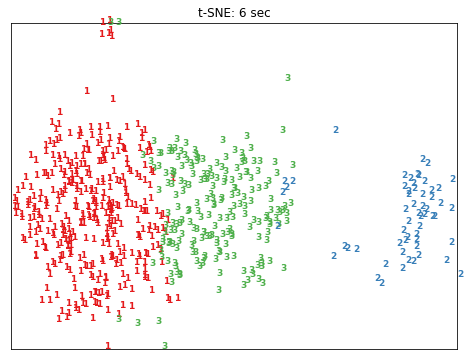

In [428]:
#visualize and tag tsne graph using kmeans result 
print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, perplexity =10,init='pca', learning_rate=500,early_exaggeration=2.0,random_state=6250,method='exact')  
t0 = time()
case_tsne = tsne.fit_transform(case_embedding)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
x_min, x_max = np.min(case_tsne, 0), np.max(case_tsne, 0)
case_tsne = (case_tsne - x_min) / (x_max - x_min)

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i in range(case_tsne.shape[0]):
    plt.text(case_tsne[i, 0], case_tsne[i, 1], str(case_class[i]),
                color=plt.cm.Set1(case_class[i]/10.0),
                fontdict={'weight': 'bold', 'size': 9})

plt.xticks([]), plt.yticks([])
plt.title("t-SNE: %.2g sec" % (t1 - t0))


## TopK n-gram in Each Cluster
trying to find structures and patterns in each subgroup

In [429]:
from nltk import ngrams
import operator

def topk(X_case, case_class, cluster,k,n):
    codes_class=[]
    d={}
    for i in np.where(case_class==cluster)[0]:
        codes_class += list(ngrams(X_case[i],n))
    for e in codes_class:
        d[e] = d.get(e,0)+1
    d2 = {k: v/float(sum(d.values())) for (k,v) in d.items()}

    sorted_code = sorted(d2.items(), key=operator.itemgetter(1),reverse=True)

    return [x[0] for x in sorted_code[:k]]

In [430]:
event_id_dict = dict(zip(all_events.EVE_INDEX,all_events.EVENTS))

In [431]:
def top_grams(event_pairs):
    return [tuple(event_id_dict[x] for x in tup) for (i,tup) in enumerate(event_pairs)]

In [432]:
import pprint
pp = pprint.PrettyPrinter()
for c in range(1,4):
    pp.pprint('cluster:' + str(c))
    onegram = topk(X_case,case_class,c,10,1)
    twogram = topk(X_case,case_class,c,10,2)
    threegram = topk(X_case,case_class,c,10,3)
    pp.pprint(top_grams(onegram))
    pp.pprint(top_grams(twogram))
    pp.pprint(top_grams(threegram))
    print("")
    print("")
    

'cluster:1'
[('timetoken0-2day',),
 ('potassium chloride',),
 ('d5w',),
 ('metoprolol',),
 ('ns',),
 ('insulin',),
 ('furosemide',),
 ('magnesium sulfate',),
 ('sodium chloride 0.9%  flush',),
 ('acetaminophen',)]
[('potassium chloride', 'potassium chloride'),
 ('d5w', 'd5w'),
 ('insulin', 'insulin'),
 ('metoprolol', 'metoprolol'),
 ('ns', 'ns'),
 ('timetoken0-2day', 'd5w'),
 ('furosemide', 'furosemide'),
 ('timetoken0-2day', 'warfarin'),
 ('timetoken0-2day', 'metoprolol'),
 ('acetaminophen', 'sodium chloride 0.9%  flush')]
[('insulin', 'insulin', 'insulin'),
 ('d5w', 'd5w', 'd5w'),
 ('potassium chloride', 'potassium chloride', 'potassium chloride'),
 ('metoprolol', 'metoprolol', 'metoprolol'),
 ('ns', 'ns', 'ns'),
 ('timetoken0-2day', 'd5w', 'd5w'),
 ('0.9% sodium chloride', '0.9% sodium chloride', '0.9% sodium chloride'),
 ('d5w', 'd5w', 'acetaminophen'),
 ('metoprolol tartrate', 'metoprolol tartrate', 'metoprolol tartrate'),
 ('d5w', 'acetaminophen', 'acetaminophen')]


'cluster:2'


## find most salient feature
using the output from convolutional layer, an approximation of the gradient for each groups of patient events

In [437]:
#model2 = Model(inputs = input_events_r,outputs = x_2_r)
model2 = Model(inputs = input_events,outputs = x_2)
model3 = Model(inputs = input_events,outputs = x_3)
model4 = Model(inputs = input_events,outputs = x_4)

In [448]:
model2.predict(X).shape

(1944, 491, 4)

In [449]:
#the temperal dimention of output size is max_events - n 
patient_feature_weights2 = model2.predict(X).reshape(4, 1944, 491)
patient_feature_weights3 = model3.predict(X).reshape(4, 1944, 490)
patient_feature_weights4 = model4.predict(X).reshape(4, 1944, 489)

In [460]:
def get_top_events(filter_output, top_num = 500, filter_size = 2):
    top = filter_output.flatten().argsort()[-top_num:]
    
    top_feature_med = []
    top_feature_diag = []
    top_feature_proc = []
    
    event_width = filter_output.shape[1]
    for idx in top:
        patient_idx = int(np.floor(idx/event_width))
        event_idx =  idx%event_width
        real_patient_id = all_patients_shuffle[patient_idx]
        real_event_id = X[patient_idx,event_idx:event_idx+2]
        if np.sum(real_event_id) !=0:
            for eve in real_event_id:
                if eve >= 1612:
                    top_feature_med.append(eve)
                elif eve < 1612 and eve >= 944:
                    top_feature_proc.append(eve)
                elif eve < 944 and eve > 0:
                    top_feature_diag.append(eve)
                
    top_counts_med = pd.Series(top_feature_med).value_counts()
    top_counts_diag = pd.Series(top_feature_diag).value_counts()
    top_counts_proc = pd.Series(top_feature_proc).value_counts()
    
    top_counts_med = pd.DataFrame({"index": top_counts_med.index, "counts":top_counts_med})
    top_counts_diag = pd.DataFrame({"index": top_counts_diag.index, "counts":top_counts_diag})
    top_counts_proc = pd.DataFrame({"index": top_counts_proc.index, "counts":top_counts_proc})
    
    return top_counts_med, top_counts_diag, top_counts_proc

In [461]:
eve_list_med = []
eve_list_diag = []
eve_list_proc = []
for i in range(4):
    te2_med, te2_diag, te2_proc = get_top_events(patient_feature_weights2[i])
    te3_med, te3_diag, te3_proc = get_top_events(patient_feature_weights3[i])
    te4_med, te4_diag, te4_proc = get_top_events(patient_feature_weights4[i])
    
    eve_list_med.append(te2_med)
    eve_list_med.append(te3_med)
    eve_list_med.append(te4_med)
    
    eve_list_diag.append(te2_diag)
    eve_list_diag.append(te3_diag)
    eve_list_diag.append(te4_diag)
    
    eve_list_proc.append(te2_proc)
    eve_list_proc.append(te3_proc)
    eve_list_proc.append(te4_proc)
    

In [468]:
eve_counts_d = pd.concat(eve_list_diag, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:10]
final_top_diag = eve_counts_d.merge(all_events, how = "left", left_index = True, right_on = "EVE_INDEX")

eve_counts_p = pd.concat(eve_list_proc, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:10]
final_top_proc = eve_counts_p.merge(all_events, how = "left", left_index = True, right_on = "EVE_INDEX")

eve_counts_m = pd.concat(eve_list_med, axis = 0).groupby("index").sum().sort_values(by = "counts", ascending = False)[:10]
final_top_med = eve_counts_m.merge(all_events, how = "left", left_index = True, right_on = "EVE_INDEX")

In [469]:
final_top_diag 

,counts,EVE_INDEX,EVENTS
1787615,19,206,###diag276
3135580,16,493,###diag599
2515780,15,326,###diag401
1872725,14,181,###diag250
2918194,12,215,###diag285
3681134,11,346,###diag427
4279001,10,479,###diag585
3307207,10,906,###diagV45
2824092,10,478,###diag584
627241,10,422,###diag518


In [471]:
final_top_med

,counts,EVE_INDEX,EVENTS
42778,356,5479,timetoken0-2day
2054384,152,3413,insulin
2590,127,4552,potassium chloride
424350,81,4271,ns
4687359,76,2623,d5w
3933302,74,1731,0.9% sodium chloride
3276609,73,3134,furosemide
4968506,63,4902,sodium chloride 0.9% flush
923114,62,3882,metoprolol
203912,61,3469,iso-osmotic dextrose


In [485]:
final_top_output = pd.DataFrame({"Med": final_top_med["EVENTS"].values
                                 ,"Diag": final_top_diag["EVENTS"].apply(lambda x: x[-3:]).values
                                 ,"Proc":final_top_proc["EVENTS"].apply(lambda x: x[-3:]).values}, index = np.arange(10))


In [481]:
raw_icd_diag = pd.read_csv("raw_mimic_data/D_ICD_DIAGNOSES.csv")
raw_icd_proc = pd.read_csv("raw_mimic_data/D_ICD_PROCEDURES.csv")

In [479]:
final_top_output.to_csv("strong_indicators.csv")

In [486]:
final_top_output

,Diag,Med,Proc
0,276,timetoken0-2day,389
1,599,insulin,885
2,401,potassium chloride,361
3,250,ns,372
4,285,d5w,399
5,427,0.9% sodium chloride,396
6,585,furosemide,967
7,V45,sodium chloride 0.9% flush,966
8,584,metoprolol,960
9,518,iso-osmotic dextrose,360
